## Hierarchical Bayesian propulsion power models for marine vessels

This simple demo accompanies the paper with the above title, available in `http:arxiv-link-here`. We fit the following model to randomly generated synthetic data:

$P_{i} = a_iV_i^3 + b_i\cos(\alpha_i)U_{R,i}^2V_i + \varepsilon_i$,

where $a_i$ and $b_i$ are ship-specific resistance coefficients and $\varepsilon_i \sim N(0, \sigma^2_{obs,i})$. Moreover, we add a "hyper-model" that predicts the ship-specific coefficients using the vessel's mass (gross tonnage) $w_i$:

$a_i = \lambda_1 + \lambda_2w_i  + \eta_a$

$b_i = \lambda_3 + \lambda_4w_i  + \eta_b$,

where $\lambda_i$ are unknown hyperparameters and $\eta_a \sim N(0, \sigma^2_a)$ and $\eta_b \sim N(0, \sigma^2_b)$. The goal is to estimate the resistance coefficients for each ship, the hyperparameters, and the error variances, using measured values for $P_i$ (propulsion power), $V_i$ (vessel speed), $\alpha_i$ (relative wind angle) and $U_{R,i}$ (relative wind speed). The estimation is carried out with `Stan` via the `pystan` interface.

In [1]:
import numpy as np
import pystan
import matplotlib.pyplot as plt
from utils import generate_ship_data

### Generate synthetic data

First, set some "true" values for the parameters for generating the synthetic data. The parameter values are chosen from the estimation with real ship data reported in the paper.

In [2]:
true_pars = {
    'alp0': 18.6, 'alp1': 9.0, 'sig_alp': 2.4,
    'beta0': 0.45, 'beta1': 1.05, 'sig_beta': 0.4,
    'sig_obs': 2.0
}

Choose the number of ships, and randomly generate the gross tonnages for the ships. Also randomly choose the number of data points per ship that we are going to generate. Then, generate the fake data.

In [3]:
N_ships = 60
GT = np.random.uniform(0.8, 2.3, N_ships)
N_data = np.random.randint(20, 120, N_ships)

In [4]:
power_data, speed_data, wind_data = generate_ship_data(GT, N_data, true_pars)

## Stan fitting

First, turn the generated data into a suitable format required by `pystan`. Note that the data for all the ships are concatenated into single vectors. In Stan, there is currently no support for such "ragged data structures", where the number of data points between units (ships) changes.

In [5]:
vessel_data = {'N': sum(N_data),
               'K': N_ships,
               's': list(N_data),
               'mass': list(GT),
               'Pobs': list(np.concatenate(power_data)),
               'V3': list(np.concatenate(speed_data)),
               'U2V': list(np.concatenate(wind_data))}

Define the Stan model. Note how we need to use the `segment` -function to refer to the ship-specific data.

In [6]:
vessel_code = """
data {
    int N;
    int K;
    vector[N] Pobs;
    vector[N] V3;
    vector[N] U2V;
    int s[K];
    vector[K] mass;
}
parameters {
    vector[K] a;
    vector[K] b;
    vector<lower=0>[K] sigma;
    real alp0;
    real alp1;
    real beta0;
    real beta1;
    real<lower=0> sig_alp;
    real<lower=0> sig_beta;
    
}
model {
    int pos;
    pos = 1;
    for (k in 1:K) {
        segment(Pobs, pos, s[k]) ~ normal(a[k]*segment(V3, pos, s[k]) + b[k]*segment(U2V, pos, s[k]), sigma[k]);
        pos = pos + s[k];
    }
    
    a ~ normal(alp0+alp1*mass, sig_alp);
    b ~ normal(beta0+beta1*mass, sig_beta);
}
"""

In [7]:
sm = pystan.StanModel(model_code=vessel_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5753bfeb4bdcf33d061f14d6d1123b3f NOW.


In [8]:
fit = sm.sampling(data=vessel_data, iter=1000, chains=4)
print(fit)

Inference for Stan model: anon_model_5753bfeb4bdcf33d061f14d6d1123b3f.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a[1]       31.59    0.01   0.54  30.53  31.24  31.59  31.94  32.65   2193    1.0
a[2]       35.73    0.02   0.86  34.08  35.17  35.73  36.29  37.38   2916    1.0
a[3]       33.69  9.2e-3   0.45  32.81  33.39   33.7  33.99  34.56   2386    1.0
a[4]       37.74  9.4e-3   0.45  36.87  37.44  37.74  38.06   38.6   2272    1.0
a[5]       29.02    0.01   0.52   28.0  28.68  29.03  29.37  30.04   2383    1.0
a[6]        44.0    0.01   0.61   42.7  43.62  44.03  44.41  45.19   2170    1.0
a[7]        34.1  9.9e-3   0.54  33.06  33.74  34.08  34.46   35.2   2958    1.0
a[8]        29.4    0.01   0.55  28.32  29.02   29.4  29.77  30.51   2527    1.0
a[9]       28.72  9.9e-3   0.46  27.84  28.41  28.72  29.02  29.63   2175    1.0
a[1

## Plot some results

The first generated figure corresponds to `Fig. 1` in the paper.

In [9]:
pars = fit.extract(permuted=True)

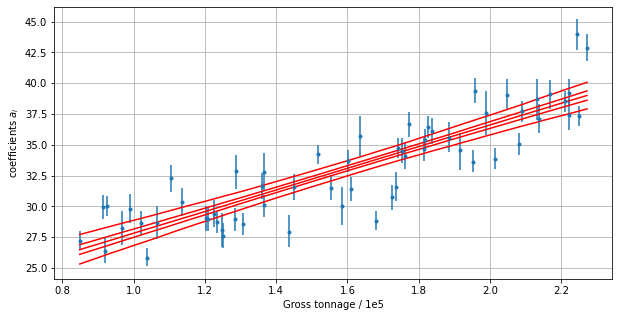

In [10]:
xx = np.linspace(min(GT),max(GT))
yy_all = (pars['alp1'][:,np.newaxis].dot(xx[np.newaxis,:]) + pars['alp0'][:,np.newaxis])
yy_perc = np.percentile(yy_all,[2.5,25,50,75,97.5],axis=0)

alims = np.percentile(pars['a'],[2.5,50,97.5],axis=0)
aerr = np.abs((alims-alims[1:2,:])[[0,2],:])

fig=plt.figure(figsize=(10,5))
plt.errorbar(GT, alims[1,:], yerr=aerr, fmt='.')
plt.plot(xx,yy_perc.T,'r-')
plt.xlabel('Gross tonnage / 1e5')
plt.ylabel('coefficients $a_i$')
plt.grid(True)
plt.show()

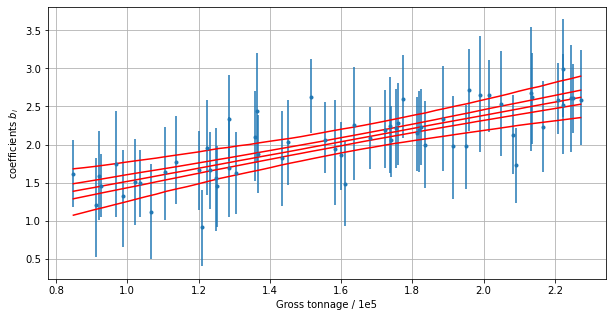

In [11]:
xx = np.linspace(min(GT),max(GT))
yy_all = (pars['beta1'][:,np.newaxis].dot(xx[np.newaxis,:]) + pars['beta0'][:,np.newaxis])
yy_perc = np.percentile(yy_all,[2.5,25,50,75,97.5],axis=0)

alims = np.percentile(pars['b'],[2.5,50,97.5],axis=0)
aerr = np.abs((alims-alims[1:2,:])[[0,2],:])

fig=plt.figure(figsize=(10,5))
plt.errorbar(GT, alims[1,:], yerr=aerr, fmt='.')
plt.plot(xx,yy_perc.T,'r-')
plt.xlabel('Gross tonnage / 1e5')
plt.ylabel('coefficients $b_i$')
plt.grid(True)
plt.show()